# Quarterback model
We've already created our dataset, so hopefully we can bring it in and it can be a relatively smooth process that can be a guide for out TE, WR and RB models.

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import sqlite3

In [297]:
from collections import defaultdict

Let's set up our error dictionaries to keep track of the models. We'll need separate models for FanDuel and DraftKings since the scoring is a little different.

In [298]:
error_dict_FD = defaultdict(float)
error_dict_DK = defaultdict(float)

Let's bring in our dataset from the database.

In [299]:
# # Connect to the SQLite database
# conn = sqlite3.connect('nfl_dfs.db')

# # Query specific columns from the table
# query = "SELECT * FROM qb_dataset"
# quarterback_df = pd.read_sql_query(query, conn)

# # Close the connection
# conn.close()

In [300]:
quarterback_df.head()

,season,week,player_id,player_display_name,team,FD_Pts,DK_Pts,FD_Pts_DvP,DK_Pts_DvP,QB_role,...,wind,div_game,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
0,2006,6,00-0000865,Charlie Batch,PIT,0.04,0.04,9.8575,10.4825,2.0,...,6.0,0.0,KC,6.5,37.0,1,0,1,21.75,15.25
1,2006,7,00-0000865,Charlie Batch,PIT,15.80,15.80,8.8600,9.6100,2.0,...,0.0,0.0,ATL,2.5,39.5,0,0,0,21.00,18.50
2,2006,12,00-0000865,Charlie Batch,PIT,0.40,0.40,15.7625,16.6375,2.0,...,4.0,1.0,BAL,-3.0,40.5,1,0,0,18.75,21.75
3,2006,14,00-0000865,Charlie Batch,PIT,-0.20,-0.20,14.6325,14.8825,2.0,...,12.0,1.0,CLE,7.0,34.0,1,0,1,20.50,13.50
4,2006,15,00-0000865,Charlie Batch,PIT,0.22,0.22,16.1475,16.6475,2.0,...,5.0,0.0,CAR,3.0,39.0,1,1,0,21.00,18.00


In [301]:
quarterback_df.tail()

,season,week,player_id,player_display_name,team,FD_Pts,DK_Pts,FD_Pts_DvP,DK_Pts_DvP,QB_role,...,wind,div_game,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
11219,2023,19,00-0039163,C.J. Stroud,HOU,23.06,23.06,16.1000,16.2250,1.0,...,0.000000,0.0,CLE,-2.5,45.0,0,0,1,21.25,23.75
11220,2023,20,00-0039163,C.J. Stroud,HOU,7.90,7.90,15.7225,16.3475,1.0,...,16.000000,0.0,BAL,-10.0,44.0,1,1,0,17.00,27.00
11221,2023,2,00-0039164,Anthony Richardson,IND,17.74,17.74,13.9200,14.5450,2.0,...,8.438166,1.0,HOU,1.0,40.0,1,0,0,20.50,19.50
11222,2023,4,00-0039164,Anthony Richardson,IND,29.60,30.60,11.8575,11.8575,1.0,...,8.438166,0.0,LA,-1.0,44.5,1,0,1,21.75,22.75
11223,2023,5,00-0039164,Anthony Richardson,IND,4.42,4.42,14.3700,15.9325,2.0,...,8.438166,1.0,TEN,-2.5,43.5,1,0,1,20.50,23.00


In [302]:
quarterback_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11224 entries, 0 to 11223
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                11224 non-null  int64  
 1   week                  11224 non-null  int64  
 2   player_id             11224 non-null  object 
 3   player_display_name   11224 non-null  object 
 4   team                  11224 non-null  object 
 5   FD_Pts                11224 non-null  float64
 6   DK_Pts                11224 non-null  float64
 7   FD_Pts_DvP            11224 non-null  float64
 8   DK_Pts_DvP            11224 non-null  float64
 9   QB_role               11224 non-null  float64
 10  completions_L8        11224 non-null  float64
 11  attempts_L8           11224 non-null  float64
 12  passing_yards_L8      11224 non-null  float64
 13  passing_tds_L8        11224 non-null  float64
 14  interceptions_L8      11224 non-null  float64
 15  sacks_L8           

In [303]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 

In [304]:
qb_model_even = quarterback_df[quarterback_df['season']%2 == 0]

In [305]:
main_df = qb_model_even

In [306]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,5522.0,2014.208620,5.162943,2006.0000,2010.000000,2014.000000,2018.000000,2022.000000
week,5522.0,9.750091,5.272662,1.0000,5.000000,10.000000,14.000000,22.000000
FD_Pts,5522.0,14.314904,8.667187,-4.0000,8.100000,14.380000,19.900000,49.320000
DK_Pts,5522.0,15.082923,9.338452,-2.8000,8.400000,14.740000,20.960000,52.320000
FD_Pts_DvP,5522.0,16.606452,3.269338,7.4000,14.295000,16.620000,18.779375,27.850000
DK_Pts_DvP,5522.0,17.501112,3.559702,7.9375,14.932500,17.455000,19.885625,30.350000
QB_role,5522.0,1.143245,0.361048,1.0000,1.000000,1.000000,1.000000,3.000000
completions_L8,5522.0,18.294558,6.626725,0.0000,15.625000,19.625000,22.842857,34.000000
attempts_L8,5522.0,29.242082,9.854806,0.1250,26.250000,31.625000,35.666667,61.000000
passing_yards_L8,5522.0,208.276123,77.333883,-3.0000,175.156250,222.812500,262.000000,423.000000


# Fixing wind
We checked that 71 mph wind for the Giants-Steelers game in 2017. Turns out it was only 7 mph.

In [307]:
main_df.loc[main_df['wind'] == 71, 'wind'] = 7

In [308]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,5522.0,2014.208620,5.162943,2006.0000,2010.000000,2014.000000,2018.000000,2022.000000
week,5522.0,9.750091,5.272662,1.0000,5.000000,10.000000,14.000000,22.000000
FD_Pts,5522.0,14.314904,8.667187,-4.0000,8.100000,14.380000,19.900000,49.320000
DK_Pts,5522.0,15.082923,9.338452,-2.8000,8.400000,14.740000,20.960000,52.320000
FD_Pts_DvP,5522.0,16.606452,3.269338,7.4000,14.295000,16.620000,18.779375,27.850000
DK_Pts_DvP,5522.0,17.501112,3.559702,7.9375,14.932500,17.455000,19.885625,30.350000
QB_role,5522.0,1.143245,0.361048,1.0000,1.000000,1.000000,1.000000,3.000000
completions_L8,5522.0,18.294558,6.626725,0.0000,15.625000,19.625000,22.842857,34.000000
attempts_L8,5522.0,29.242082,9.854806,0.1250,26.250000,31.625000,35.666667,61.000000
passing_yards_L8,5522.0,208.276123,77.333883,-3.0000,175.156250,222.812500,262.000000,423.000000


In [309]:
main_df.set_index(['season', 'week', 'player_id', 'player_display_name', 'team', 'opponent'], inplace = True)

# Correlations

In [310]:
corr_df = main_df.corr()

In [311]:
corr_df['FD_Pts'].sort_values(ascending = False)

FD_Pts                  1.000000
DK_Pts                  0.992776
passing_yards_L8        0.455490
completions_L8          0.437358
passing_tds_L8          0.426063
attempts_L8             0.412388
passing_air_yards_L8    0.400585
pred_total              0.243384
total_line              0.236444
carries_L8              0.232548
comp_pct                0.214563
rushing_yards_L8        0.194757
rushing_tds_L8          0.176714
sacks_L8                0.171356
yds_per_attempt         0.154119
td_pct                  0.138846
spread_line             0.126264
DK_Pts_DvP              0.083466
FD_Pts_DvP              0.082020
interceptions_L8        0.063616
pacr_L8                 0.043292
opp_total               0.042867
home_team               0.039084
grass                  -0.013487
div_game               -0.042500
outdoors               -0.057928
wind                   -0.082092
int_pct                -0.111464
sack_pct               -0.113107
QB_role                -0.552248
Name: FD_P

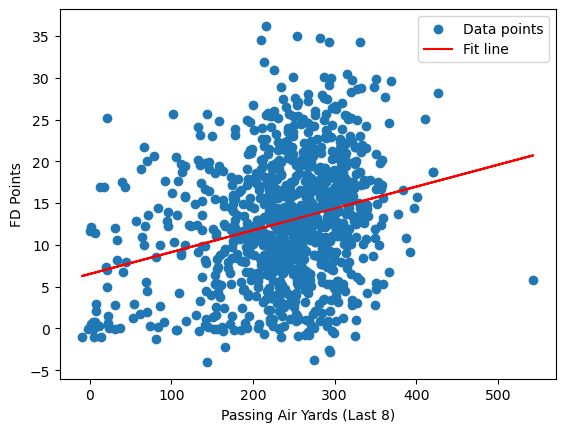

In [312]:
# Create the scatter plot
plt.scatter(main_df['passing_air_yards_L8'][:1000], main_df['FD_Pts'][:1000], label='Data points')

# Calculate the line of best fit
m, b = np.polyfit(main_df['passing_air_yards_L8'][:1000], main_df['FD_Pts'][:1000], 1)

# Plot the fit line
plt.plot(main_df['passing_air_yards_L8'][:1000], m*main_df['passing_air_yards_L8'][:1000] + b, color='red', label='Fit line')

# Add labels and legend
plt.xlabel('Passing Air Yards (Last 8)')
plt.ylabel('FD Points')
plt.legend()

# Show the plot
plt.show()


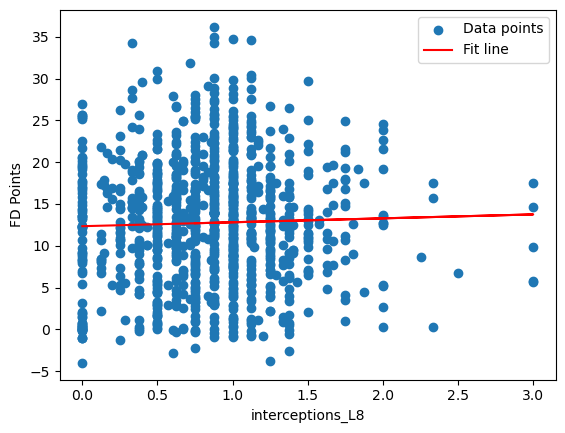

In [313]:
# Create the scatter plot
plt.scatter(main_df['interceptions_L8'][:1000], main_df['FD_Pts'][:1000], label='Data points')

# Calculate the line of best fit
m, b = np.polyfit(main_df['interceptions_L8'][:1000], main_df['FD_Pts'][:1000], 1)

# Plot the fit line
plt.plot(main_df['interceptions_L8'][:1000], m*main_df['interceptions_L8'][:1000] + b, color='red', label='Fit line')

# Add labels and legend
plt.xlabel('interceptions_L8')
plt.ylabel('FD Points')
plt.legend()

# Show the plot
plt.show()

In [314]:
corr_df['DK_Pts'].sort_values(ascending = False)

DK_Pts                  1.000000
FD_Pts                  0.992776
passing_yards_L8        0.455599
completions_L8          0.437459
passing_tds_L8          0.427524
attempts_L8             0.411831
passing_air_yards_L8    0.399742
pred_total              0.246849
total_line              0.245450
carries_L8              0.220635
comp_pct                0.213130
rushing_yards_L8        0.183319
rushing_tds_L8          0.171593
sacks_L8                0.165899
yds_per_attempt         0.153826
td_pct                  0.139635
spread_line             0.123766
DK_Pts_DvP              0.084818
FD_Pts_DvP              0.083408
interceptions_L8        0.062032
opp_total               0.050320
pacr_L8                 0.041925
home_team               0.035659
grass                  -0.016048
div_game               -0.043721
outdoors               -0.062022
wind                   -0.085288
int_pct                -0.109183
sack_pct               -0.114214
QB_role                -0.540567
Name: DK_P

In [315]:
X_FD = main_df.drop(columns = ['FD_Pts', 'DK_Pts'])
X_DK = main_df.drop(columns = ['FD_Pts', 'DK_Pts'])

In [316]:
y_FD = main_df[['FD_Pts']]
y_DK = main_df[['DK_Pts']]

In [317]:
X_FD_train, X_FD_test, y_FD_train, y_FD_test = train_test_split(X_FD, y_FD, test_size = .25, random_state = 42)

In [318]:
X_DK_train, X_DK_test, y_DK_train, y_DK_test = train_test_split(X_DK, y_DK, test_size = .25, random_state = 42)

In [319]:
from sklearn.preprocessing import StandardScaler

In [320]:
# Initialize the scaler
scaler_fd = StandardScaler()
scaler_dk = StandardScaler()

In [321]:
# Fit the scaler on the training data and transform the training data for FanDuel
X_FD_train_scaled = scaler_fd.fit_transform(X_FD_train)

In [322]:
# Use the already-fitted scaler to transform the test data for FanDuel
X_FD_test_scaled = scaler_fd.transform(X_FD_test)

In [323]:
# Fit the scaler on the training data and transform the training data for DraftKings
X_DK_train_scaled = scaler_dk.fit_transform(X_DK_train)

In [324]:
# Use the already-fitted scaler to transform the test data for DraftKings
X_DK_test_scaled = scaler_dk.transform(X_DK_test)

In [325]:
X_FD_scaled_df = pd.DataFrame(X_FD_train_scaled, columns = X_FD_train.columns)

In [326]:
# Check the mean and standard deviation of the scaled data
print("FanDuel Scaled Data - Mean:")
print(X_FD_scaled_df.mean(axis=0))

print("\nFanDuel Scaled Data - Standard Deviation:")
print(X_FD_scaled_df.std(axis=0))

FanDuel Scaled Data - Mean:
FD_Pts_DvP              4.804443e-16
DK_Pts_DvP              5.936918e-16
QB_role                 2.076206e-16
completions_L8          1.286904e-16
attempts_L8            -1.870301e-16
passing_yards_L8       -2.179158e-16
passing_tds_L8         -7.893013e-17
interceptions_L8       -1.295484e-16
sacks_L8               -4.547062e-17
passing_air_yards_L8    5.833966e-17
pacr_L8                 6.949283e-17
carries_L8              1.638658e-16
rushing_yards_L8       -3.431745e-18
rushing_tds_L8          7.549838e-17
comp_pct                5.971236e-16
yds_per_attempt        -1.630079e-17
td_pct                  2.573809e-17
sack_pct               -2.488015e-17
int_pct                -5.147617e-18
wind                    2.166289e-17
div_game                4.246784e-17
spread_line             8.579362e-19
total_line             -1.278325e-16
outdoors               -1.372698e-17
grass                  -5.490791e-17
home_team               6.863489e-18
pred_total

In [327]:
X_DK_scaled_df = pd.DataFrame(X_DK_train_scaled, columns = X_DK_train.columns)

In [328]:
# Check the mean and standard deviation of the scaled data
print("\nDraftKings Scaled Data - Mean:")
print(X_DK_scaled_df.mean(axis=0))

print("\nDraftKings Scaled Data - Standard Deviation:")
print(X_DK_scaled_df.std(axis=0))


DraftKings Scaled Data - Mean:
FD_Pts_DvP              4.804443e-16
DK_Pts_DvP              5.936918e-16
QB_role                 2.076206e-16
completions_L8          1.286904e-16
attempts_L8            -1.870301e-16
passing_yards_L8       -2.179158e-16
passing_tds_L8         -7.893013e-17
interceptions_L8       -1.295484e-16
sacks_L8               -4.547062e-17
passing_air_yards_L8    5.833966e-17
pacr_L8                 6.949283e-17
carries_L8              1.638658e-16
rushing_yards_L8       -3.431745e-18
rushing_tds_L8          7.549838e-17
comp_pct                5.971236e-16
yds_per_attempt        -1.630079e-17
td_pct                  2.573809e-17
sack_pct               -2.488015e-17
int_pct                -5.147617e-18
wind                    2.166289e-17
div_game                4.246784e-17
spread_line             8.579362e-19
total_line             -1.278325e-16
outdoors               -1.372698e-17
grass                  -5.490791e-17
home_team               6.863489e-18
pred_t

In [329]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [330]:
from sklearn.metrics import mean_absolute_error

In [331]:
from sklearn.model_selection import GridSearchCV

# K Nearest Neighbors
## FanDuel

In [332]:
# Lists to store the RMSE values and corresponding number of neighbors
# rmse_list_FD = []
# neighbors_list_FD = []

In [333]:
param_grid = {
    'n_neighbors': range(1, 101),  # Testing n_neighbors from 1 to 100
}

In [334]:
knn_FD = KNeighborsRegressor()

In [335]:
grid_search = GridSearchCV(knn_FD, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [336]:
grid_search.fit(X_FD_train_scaled, y_FD_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 101)},
             scoring='neg_mean_squared_error', verbose=1)

In [337]:
# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best model
best_knn_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_knn_model.predict(X_FD_test_scaled)

best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
# Calculate and print the final errors
print(f"Mean Absolute Error: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Root Mean Squared Error: {best_rmse}")

Best parameters: {'n_neighbors': 35}
Mean Absolute Error: 5.581500775835316
Root Mean Squared Error: 7.077679118367947


In [338]:
error_dict_FD['KNN'] = {'best_params': best_params, 'best_rmse': best_rmse}

## DraftKings

In [339]:
knn_DK = KNeighborsRegressor()

In [340]:
grid_search = GridSearchCV(knn_DK, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [341]:
grid_search.fit(X_DK_train_scaled, y_DK_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 101)},
             scoring='neg_mean_squared_error', verbose=1)

In [342]:
# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best model
best_knn_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_knn_model.predict(X_DK_test_scaled)

best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
# Calculate and print the final errors
print(f"Mean Absolute Error: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Root Mean Squared Error: {best_rmse}")

Best parameters: {'n_neighbors': 35}
Mean Absolute Error: 6.078503775731871
Root Mean Squared Error: 7.704548048681453


In [343]:
error_dict_DK['KNN'] = {'best_params': best_params, 'best_rmse': best_rmse}

# Linear Regression

## FanDuel

In [344]:
base_LR_FD = LinearRegression()

In [345]:
base_LR_FD.fit(X_FD_train_scaled, y_FD_train)

LinearRegression()

In [346]:
base_LR_FD_pred = base_LR_FD.predict(X_FD_test_scaled)

In [347]:
print(f"R_squared_train: {base_LR_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"R_squared_test: {base_LR_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"MAE: {mean_absolute_error(y_FD_test, base_LR_FD_pred)}")
print(f"MSE: {mean_squared_error(y_FD_test, base_LR_FD_pred)}")
print(f"RMSE: {mean_squared_error(y_FD_test, base_LR_FD_pred, squared = False)}")

R_squared_train: 0.42686396082398403
R_squared_test: 0.3982738890340183
MAE: 5.340233944477924
MSE: 46.94719042582289
RMSE: 6.851801983845045


In [348]:
from sklearn.linear_model import Ridge

In [349]:
alpha_values = np.linspace(0.1, 100, 50)

In [350]:
param_grid = {'alpha': alpha_values}
Ridge_LR_FD = Ridge()
Ridge_CV_FD = GridSearchCV(Ridge_LR_FD, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
Ridge_CV_FD.fit(X_FD_train_scaled, y_FD_train)
best_params = Ridge_CV_FD.best_params_
print(f"Ridge_model best params: {best_params}")
print(f"Ridge_model best score: {-Ridge_CV_FD.best_score_}")

Ridge_model best params: {'alpha': 36.79795918367348}
Ridge_model best score: 6.559775768704431


In [351]:
best_ridge_FD = Ridge(alpha=36.79795918367348, random_state=42)
best_ridge_FD.fit(X_FD_train_scaled, y_FD_train)  # Use the correct variable name
y_pred = best_ridge_FD.predict(X_FD_test_scaled)  # Use the correct variable name

best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
print(f"best_ridge train R-squared: {best_ridge_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"best_ridge test R-squared: {best_ridge_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"best_ridge MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"best_ridge RMSE: {best_rmse}")
print(f"best_ridge MSE: {mean_squared_error(y_FD_test, y_pred)}")

best_ridge train R-squared: 0.4265494180098788
best_ridge test R-squared: 0.39830172984368606
best_ridge MAE: 5.347921729257699
best_ridge RMSE: 6.851643471593359
best_ridge MSE: 46.945018261827904


In [352]:
error_dict_FD['Linear_Regression'] = {'best_params': best_params, 'best_rmse': best_rmse}

## DraftKings

In [353]:
base_LR_DK = LinearRegression()

In [354]:
base_LR_DK.fit(X_DK_train_scaled, y_DK_train)

LinearRegression()

In [355]:
base_LR_DK_pred = base_LR_DK.predict(X_DK_test_scaled)

In [356]:
print(f"R_squared_train: {base_LR_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"R_squared_test: {base_LR_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"MAE: {mean_absolute_error(y_DK_test, base_LR_DK_pred)}")
print(f"MSE: {mean_squared_error(y_DK_test, base_LR_DK_pred)}")
print(f"RMSE: {mean_squared_error(y_DK_test, base_LR_DK_pred, squared = False)}")

R_squared_train: 0.41584987238061843
R_squared_test: 0.3878165431738878
MAE: 5.822807114710806
MSE: 55.808573217514265
RMSE: 7.470513584588028


In [357]:
alpha_values = np.linspace(0.1, 100, 50)

In [358]:
param_grid = {'alpha': alpha_values}
Ridge_LR_DK = Ridge()
Ridge_CV_DK = GridSearchCV(Ridge_LR_DK, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
Ridge_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = Ridge_CV_DK.best_params_
print(f"Ridge_model best params: {best_params}")
print(f"Ridge_model best score: {-Ridge_CV_DK.best_score_}")

Ridge_model best params: {'alpha': 24.565306122448984}
Ridge_model best score: 7.126070971354375


In [359]:
best_ridge_DK = Ridge(alpha=24.565306122448984, random_state=42)
best_ridge_DK.fit(X_DK_train_scaled, y_DK_train)  # Use the correct variable name
y_pred = best_ridge_DK.predict(X_DK_test_scaled)  # Use the correct variable name

best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
print(f"best_ridge train R-squared: {best_ridge_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"best_ridge test R-squared: {best_ridge_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"best_ridge MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"best_ridge RMSE: {best_rmse}")
print(f"best_ridge MSE: {mean_squared_error(y_DK_test, y_pred)}")

best_ridge train R-squared: 0.41562934174267885
best_ridge test R-squared: 0.38787745190510214
best_ridge MAE: 5.827783726793055
best_ridge RMSE: 7.470141938786919
best_ridge MSE: 55.803020585623194


In [360]:
error_dict_DK['Linear_Regression'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [361]:
error_dict_DK

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.704548048681453},
             'Linear_Regression': {'best_params': {'alpha': 24.565306122448984},
              'best_rmse': 7.470141938786919}})

In [362]:
from sklearn.metrics import make_scorer

In [363]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [364]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest

## FanDuel

In [365]:
base_RF_FD = RandomForestRegressor(random_state = 42)

In [366]:
base_RF_FD.fit(X_FD_train_scaled, y_FD_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [367]:
base_RF_FD_pred = base_RF_FD.predict(X_FD_test_scaled)

In [368]:
print(f"R_squared_train: {base_RF_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"R_squared_test: {base_RF_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"MAE: {mean_absolute_error(y_FD_test, base_RF_FD_pred)}")
print(f"MSE: {mean_squared_error(y_FD_test, base_RF_FD_pred)}")
print(f"RMSE: {mean_squared_error(y_FD_test, base_RF_FD_pred, squared = False)}")

R_squared_train: 0.9172535126454029
R_squared_test: 0.38187930824730143
MAE: 5.356937291817523
MSE: 48.22630976619841
RMSE: 6.944516525014424


In [369]:
from sklearn.model_selection import RandomizedSearchCV

In [370]:
param_dist = {'max_depth': [3, 6, 9, 12, 15],\
              'n_estimators': [100, 300, 500, 700],\
             'min_samples_split': [2, 5, 10],\
              'min_samples_leaf': [1, 2, 4]}
y_FD_train = y_FD_train.values.ravel()
RF_Random_CV_FD = RandomizedSearchCV(base_RF_FD, param_distributions=param_dist, n_iter=60, scoring=rmse_scorer,\
                                     cv=3, n_jobs=2, verbose=2, random_state=42)
RF_Random_CV_FD.fit(X_FD_train_scaled, y_FD_train)
best_params = RF_Random_CV_FD.best_params_
print(f"Tuned Random Forest Best Estimator: {RF_Random_CV_FD.best_estimator_}")
print(f"Tuned Random Forest Best Score: {RF_Random_CV_FD.best_score_}")
print(f"Tuned Random Forest Best Params: {best_params}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Tuned Random Forest Best Estimator: RandomForestRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=300, random_state=42)
Tuned Random Forest Best Score: -6.495983191348486
Tuned Random Forest Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 6}


In [371]:
best_RF_FD = RandomForestRegressor(max_depth=6, n_estimators=300, min_samples_split = 5, min_samples_leaf = 4, random_state=42)
best_RF_FD.fit(X_FD_train_scaled, y_FD_train)  # Correct the variable name for consistency
y_pred = best_RF_FD.predict(X_FD_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
print(f"Best_RF Train R-squared: {best_RF_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"Best_RF Test R-squared: {best_RF_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"Best_RF MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Best_RF RMSE: {best_rmse}")
print(f"Best_RF MSE: {mean_squared_error(y_FD_test, y_pred)}")

Best_RF Train R-squared: 0.5057513081130933
Best_RF Test R-squared: 0.40828760962168187
Best_RF MAE: 5.230291444694439
Best_RF RMSE: 6.794550117882793
Best_RF MSE: 46.16591130442109


In [372]:
error_dict_FD['Random_Forest'] = {'best_params': best_params, 'best_rmse': best_rmse}

# DraftKings
Since the param_grid took a while for FanDuel, even with a randomized search, we're going to reel the grid in a little bit for DraftKings.

In [374]:
base_RF_DK = RandomForestRegressor(random_state = 42)

In [375]:
base_RF_DK.fit(X_DK_train_scaled, y_DK_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [376]:
base_RF_DK_pred = base_RF_DK.predict(X_DK_test_scaled)

In [377]:
print(f"R_squared_train: {base_RF_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"R_squared_test: {base_RF_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"MAE: {mean_absolute_error(y_DK_test, base_RF_DK_pred)}")
print(f"MSE: {mean_squared_error(y_DK_test, base_RF_DK_pred)}")
print(f"RMSE: {mean_squared_error(y_DK_test, base_RF_DK_pred, squared = False)}")

R_squared_train: 0.9158434037532067
R_squared_test: 0.37311146654056726
MAE: 5.8336713975380174
MSE: 57.14913434638668
RMSE: 7.559704646769388


In [378]:
param_dist = {'max_depth': [3, 6, 9, 12],\
              'n_estimators': [100, 300, 500],\
             'min_samples_split': [2, 5, 10],\
              'min_samples_leaf': [1, 2, 4]}
y_DK_train = y_DK_train.values.ravel()
RF_Random_CV_DK = RandomizedSearchCV(base_RF_DK, param_distributions=param_dist, n_iter=36, scoring=rmse_scorer,\
                                     cv=3, n_jobs=2, verbose=2, random_state=42)
RF_Random_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = RF_Random_CV_DK.best_params_
print(f"Tuned Random Forest Best Estimator: {RF_Random_CV_DK.best_estimator_}")
print(f"Tuned Random Forest Best Score: {RF_Random_CV_DK.best_score_}")
print(f"Tuned Random Forest Best Params: {best_params}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Tuned Random Forest Best Estimator: RandomForestRegressor(max_depth=6, min_samples_leaf=4, n_estimators=500,
                      random_state=42)
Tuned Random Forest Best Score: -7.062306044854563
Tuned Random Forest Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 6}


In [379]:
best_RF_DK = RandomForestRegressor(max_depth=6, n_estimators=500, min_samples_split = 2, min_samples_leaf = 4, random_state=42)
best_RF_DK.fit(X_DK_train_scaled, y_DK_train)  # Correct the variable name for consistency
y_pred = best_RF_DK.predict(X_DK_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
print(f"Best_RF Train R-squared: {best_RF_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Best_RF Test R-squared: {best_RF_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Best_RF MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Best_RF RMSE: {best_rmse}")
print(f"Best_RF MSE: {mean_squared_error(y_DK_test, y_pred)}")

Best_RF Train R-squared: 0.4953441848044511
Best_RF Test R-squared: 0.3984614243131859
Best_RF MAE: 5.696693365299007
Best_RF RMSE: 7.405278678453883
Best_RF MSE: 54.838152305563696


In [380]:
error_dict_DK['Random_Forest'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [381]:
error_dict_DK

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.704548048681453},
             'Linear_Regression': {'best_params': {'alpha': 24.565306122448984},
              'best_rmse': 7.470141938786919},
             'Random_Forest': {'best_params': {'n_estimators': 500,
               'min_samples_split': 2,
               'min_samples_leaf': 4,
               'max_depth': 6},
              'best_rmse': 7.405278678453883}})

In [382]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boost

## DraftKings
For this one, we'll do DraftKings first, then if we have to compromise the grid, this time it will be FanDuel that gets the reduced grid.

In [383]:
base_GB_DK = GradientBoostingRegressor(random_state = 42)

In [384]:
base_GB_DK.fit(X_DK_train_scaled, y_DK_train)

GradientBoostingRegressor(random_state=42)

In [385]:
y_pred = base_GB_DK.predict(X_DK_test_scaled)

In [386]:
print(f"Base GB R_squared_train: {base_GB_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Base GB R_squared_test: {base_GB_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Base GB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Base GB MSE: {mean_squared_error(y_DK_test, y_pred)}")
print(f"Base GB RMSE: {mean_squared_error(y_DK_test, y_pred, squared = False)}")

Base GB R_squared_train: 0.5156171250949564
Base GB R_squared_test: 0.39074198888195
Base GB MAE: 5.760131997569609
Base GB MSE: 55.54188036723912
Base GB RMSE: 7.4526425090191415


In [387]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],  # Expanded learning rates
    'max_depth': [2, 4, 6]
}

In [388]:
GB_CV_DK = RandomizedSearchCV(base_GB_DK, param_dist, scoring=rmse_scorer, cv = 3, n_iter = 50, n_jobs = 2, verbose = 3)
GB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = GB_CV_DK.best_params_
print(f"Tuned Gradient Boost Best Estimator: {GB_CV_DK.best_estimator_}")
print(f"Tuned Gradient Boost Best Score: {GB_CV_DK.best_score_}")
print(f"Tuned Gradient Boost Best Params: {best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuned Gradient Boost Best Estimator: GradientBoostingRegressor(max_depth=2, random_state=42)
Tuned Gradient Boost Best Score: -7.075255405795531
Tuned Gradient Boost Best Params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}


In [389]:
best_GB_DK = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate = 0.1, random_state=42)
best_GB_DK.fit(X_DK_train_scaled, y_DK_train)  # Correct the variable name for consistency
y_pred = best_GB_DK.predict(X_DK_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
print(f"Best_GB Train R-squared: {best_GB_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Best_GB Test R-squared: {best_GB_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Best_GB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Best_GB RMSE: {best_rmse}")
print(f"Best_GB MSE: {mean_squared_error(y_DK_test, y_pred)}")

Best_GB Train R-squared: 0.4702669310080311
Best_GB Test R-squared: 0.39261562035386444
Best_GB MAE: 5.767116372123758
Best_GB RMSE: 7.44117424990967
Best_GB MSE: 55.37107421751874


In [390]:
error_dict_DK['Gradient_Boost'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [391]:
error_dict_DK

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.704548048681453},
             'Linear_Regression': {'best_params': {'alpha': 24.565306122448984},
              'best_rmse': 7.470141938786919},
             'Random_Forest': {'best_params': {'n_estimators': 500,
               'min_samples_split': 2,
               'min_samples_leaf': 4,
               'max_depth': 6},
              'best_rmse': 7.405278678453883},
             'Gradient_Boost': {'best_params': {'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.1},
              'best_rmse': 7.44117424990967}})

## FanDuel

In [392]:
base_GB_FD = GradientBoostingRegressor(random_state = 42)

In [393]:
base_GB_FD.fit(X_FD_train_scaled, y_FD_train)

GradientBoostingRegressor(random_state=42)

In [394]:
y_pred = base_GB_FD.predict(X_FD_test_scaled)

In [395]:
print(f"Base GB R_squared_train: {base_GB_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"Base GB R_squared_test: {base_GB_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"Base GB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Base GB MSE: {mean_squared_error(y_FD_test, y_pred)}")
print(f"Base GB RMSE: {mean_squared_error(y_FD_test, y_pred, squared = False)}")

Base GB R_squared_train: 0.5264194237956745
Base GB R_squared_test: 0.39830581150487
Base GB MAE: 5.310633126335354
Base GB MSE: 46.94469980710014
Base GB RMSE: 6.851620232258947


In [397]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Expanded learning rates
    'max_depth': [2, 3, 4]
}

In [398]:
GB_CV_FD = RandomizedSearchCV(base_GB_FD, param_dist, scoring=rmse_scorer, cv = 3, n_iter = 36, n_jobs = 2, verbose = 3)
GB_CV_FD.fit(X_FD_train_scaled, y_FD_train)
best_params = GB_CV_FD.best_params_
print(f"Tuned Gradient Boost Best Estimator: {GB_CV_FD.best_estimator_}")
print(f"Tuned Gradient Boost Best Score: {GB_CV_FD.best_score_}")
print(f"Tuned Gradient Boost Best Params: {best_params}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Tuned Gradient Boost Best Estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, random_state=42)
Tuned Gradient Boost Best Score: -6.516655856776173
Tuned Gradient Boost Best Params: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.05}


In [399]:
best_GB_FD = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate = 0.05, random_state=42)
best_GB_FD.fit(X_FD_train_scaled, y_FD_train)  # Correct the variable name for consistency
y_pred = best_GB_FD.predict(X_FD_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
print(f"Best_GB Train R-squared: {best_GB_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"Best_GB Test R-squared: {best_GB_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"Best_GB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Best_GB RMSE: {best_rmse}")
print(f"Best_GB MSE: {mean_squared_error(y_FD_test, y_pred)}")

Best_GB Train R-squared: 0.45811779291510357
Best_GB Test R-squared: 0.4008588042419452
Best_GB MAE: 5.304478169656613
Best_GB RMSE: 6.837069043873724
Best_GB MSE: 46.74551311069636


In [400]:
error_dict_FD['Gradient_Boost'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [401]:
error_dict_FD

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.077679118367947},
             'Linear_Regression': {'best_params': {'alpha': 36.79795918367348},
              'best_rmse': 6.851643471593359},
             'Random_Forest': {'best_params': {'n_estimators': 300,
               'min_samples_split': 5,
               'min_samples_leaf': 4,
               'max_depth': 6},
              'best_rmse': 6.794550117882793},
             'Gradient_Boost': {'best_params': {'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.05},
              'best_rmse': 6.837069043873724}})

# XGBoost

## FanDuel

In [402]:
import xgboost as xgb

In [403]:
base_XGB_FD = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [404]:
# Fit the best model on the training data
base_XGB_FD.fit(X_FD_train_scaled, y_FD_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [405]:
# Make predictions on the test data
y_pred = base_XGB_FD.predict(X_FD_test_scaled)

In [406]:
print(f"Base XGB R_squared_train: {base_XGB_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"Base XGB R_squared_test: {base_XGB_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"Base XGB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Base XGB MSE: {mean_squared_error(y_FD_test, y_pred)}")
print(f"Base XGB RMSE: {mean_squared_error(y_FD_test, y_pred, squared=False)}")

Base XGB R_squared_train: 0.9507239865058638
Base XGB R_squared_test: 0.3151580873454596
Base XGB MAE: 5.592475257761222
Base XGB MSE: 53.43195699678577
Base XGB RMSE: 7.309716615354235


In [407]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [2, 4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [408]:
# Set up the GridSearchCV with XGBoost
XGB_CV_FD = RandomizedSearchCV(base_XGB_FD, param_dist, scoring=rmse_scorer, n_iter = 100, cv=3, n_jobs=2, verbose=3)
XGB_CV_FD.fit(X_FD_train_scaled, y_FD_train)
best_params = XGB_CV_FD.best_params_
print(f"Tuned XGBoost Best Estimator: {XGB_CV_FD.best_estimator_}")
print(f"Tuned XGBoost Best Score: {XGB_CV_FD.best_score_}")
print(f"Tuned XGBoost Best Params: {best_params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Tuned XGBoost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Tuned XGBoost Best Score: -6.506796603196059
Tuned XGBoost Best Params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 2, 'l

In [409]:
best_XGB_FD = xgb.XGBRegressor(max_depth=2, n_estimators=100, learning_rate=0.05,\
                               subsample = 0.6, reg_lambda = 1.5, reg_alpha = 0.01,\
                               gamma = 0.3, colsample_bytree = 1.0, objective='reg:squarederror', random_state=42)

In [410]:
best_XGB_FD.fit(X_FD_train_scaled, y_FD_train)
y_pred = best_XGB_FD.predict(X_FD_test_scaled)

In [411]:
# Print evaluation metrics for the best model
best_rmse = mean_squared_error(y_FD_test, y_pred, squared=False)
print(f"Best_XGB Train R-squared: {best_XGB_FD.score(X_FD_train_scaled, y_FD_train)}")
print(f"Best_XGB Test R-squared: {best_XGB_FD.score(X_FD_test_scaled, y_FD_test)}")
print(f"Best_XGB MAE: {mean_absolute_error(y_FD_test, y_pred)}")
print(f"Best_XGB RMSE: {best_rmse}")
print(f"Best_XGB MSE: {mean_squared_error(y_FD_test, y_pred)}")

Best_XGB Train R-squared: 0.45851020007727183
Best_XGB Test R-squared: 0.4028048837437981
Best_XGB MAE: 5.293067392242897
Best_XGB RMSE: 6.825956219360698
Best_XGB MSE: 46.593678308629


In [412]:
error_dict_FD['XGBoost'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [413]:
error_dict_FD

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.077679118367947},
             'Linear_Regression': {'best_params': {'alpha': 36.79795918367348},
              'best_rmse': 6.851643471593359},
             'Random_Forest': {'best_params': {'n_estimators': 300,
               'min_samples_split': 5,
               'min_samples_leaf': 4,
               'max_depth': 6},
              'best_rmse': 6.794550117882793},
             'Gradient_Boost': {'best_params': {'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.05},
              'best_rmse': 6.837069043873724},
             'XGBoost': {'best_params': {'subsample': 0.6,
               'reg_lambda': 1.5,
               'reg_alpha': 0.01,
               'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.05,
               'gamma': 0.3,
               'colsample_bytree': 1.0},
              'best_rmse': 6.825956219

In [414]:
errors_FD = pd.DataFrame(error_dict_FD)

In [415]:
errors_FD

,KNN,Linear_Regression,Random_Forest,Gradient_Boost,XGBoost
best_params,{'n_neighbors': 35},{'alpha': 36.79795918367348},"{'n_estimators': 300, 'min_samples_split': 5, ...","{'n_estimators': 100, 'max_depth': 2, 'learnin...","{'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alp..."
best_rmse,7.077679,6.851643,6.79455,6.837069,6.825956


In [416]:
errors_FD.to_csv('errors_QB_FD.csv', index = False)

In [425]:
errors_FD.loc['best_params', 'XGBoost']

{'subsample': 0.6,
 'reg_lambda': 1.5,
 'reg_alpha': 0.01,
 'n_estimators': 100,
 'max_depth': 2,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 1.0}

## DraftKings

In [417]:
base_XGB_DK = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [418]:
# Fit the best model on the training data
base_XGB_DK.fit(X_DK_train_scaled, y_DK_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [419]:
# Make predictions on the test data
y_pred = base_XGB_DK.predict(X_DK_test_scaled)

In [420]:
print(f"Base XGB R_squared_train: {base_XGB_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Base XGB R_squared_test: {base_XGB_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Base XGB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Base XGB MSE: {mean_squared_error(y_DK_test, y_pred)}")
print(f"Base XGB RMSE: {mean_squared_error(y_DK_test, y_pred, squared=False)}")

Base XGB R_squared_train: 0.9489335236119927
Base XGB R_squared_test: 0.2811677693064859
Base XGB MAE: 6.219388254486635
Base XGB MSE: 65.53101154636907
Base XGB RMSE: 8.095122701131162


In [421]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [2, 4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [422]:
# Set up the GridSearchCV with XGBoost
XGB_CV_DK = RandomizedSearchCV(base_XGB_DK, param_dist, scoring=rmse_scorer, n_iter = 100, cv=3, n_jobs=2, verbose=3)
XGB_CV_DK.fit(X_DK_train_scaled, y_DK_train)
best_params = XGB_CV_DK.best_params_
print(f"Tuned XGBoost Best Estimator: {XGB_CV_DK.best_estimator_}")
print(f"Tuned XGBoost Best Score: {XGB_CV_DK.best_score_}")
print(f"Tuned XGBoost Best Params: {best_params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Tuned XGBoost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Tuned XGBoost Best Score: -7.065917498826315
Tuned XGBoost Best Params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 2, 'lea

In [426]:
best_XGB_DK = xgb.XGBRegressor(max_depth=2, n_estimators=100, learning_rate=0.05,\
                               subsample = 0.8, reg_lambda = 1, reg_alpha = 0.01,\
                               gamma = 0.1, colsample_bytree = 1.0, objective='reg:squarederror', random_state=42)

In [427]:
best_XGB_DK.fit(X_DK_train_scaled, y_DK_train)
y_pred = best_XGB_DK.predict(X_DK_test_scaled)

In [428]:
# Print evaluation metrics for the best model
best_rmse = mean_squared_error(y_DK_test, y_pred, squared=False)
print(f"Best_XGB Train R-squared: {best_XGB_DK.score(X_DK_train_scaled, y_DK_train)}")
print(f"Best_XGB Test R-squared: {best_XGB_DK.score(X_DK_test_scaled, y_DK_test)}")
print(f"Best_XGB MAE: {mean_absolute_error(y_DK_test, y_pred)}")
print(f"Best_XGB RMSE: {best_rmse}")
print(f"Best_XGB MSE: {mean_squared_error(y_DK_test, y_pred)}")

Best_XGB Train R-squared: 0.4486701381009479
Best_XGB Test R-squared: 0.39122387382390744
Best_XGB MAE: 5.769258059433282
Best_XGB RMSE: 7.449694639196441
Best_XGB MSE: 55.497950217272184


In [429]:
error_dict_DK['XGBoost'] = {'best_params': best_params, 'best_rmse': best_rmse}

In [430]:
error_dict_DK

defaultdict(float,
            {'KNN': {'best_params': {'n_neighbors': 35},
              'best_rmse': 7.704548048681453},
             'Linear_Regression': {'best_params': {'alpha': 24.565306122448984},
              'best_rmse': 7.470141938786919},
             'Random_Forest': {'best_params': {'n_estimators': 500,
               'min_samples_split': 2,
               'min_samples_leaf': 4,
               'max_depth': 6},
              'best_rmse': 7.405278678453883},
             'Gradient_Boost': {'best_params': {'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.1},
              'best_rmse': 7.44117424990967},
             'XGBoost': {'best_params': {'subsample': 0.8,
               'reg_lambda': 1,
               'reg_alpha': 0.01,
               'n_estimators': 100,
               'max_depth': 2,
               'learning_rate': 0.05,
               'gamma': 0.1,
               'colsample_bytree': 1.0},
              'best_rmse': 7.449694639196

In [431]:
errors_DK = pd.DataFrame(error_dict_DK)

In [432]:
errors_DK

,KNN,Linear_Regression,Random_Forest,Gradient_Boost,XGBoost
best_params,{'n_neighbors': 35},{'alpha': 24.565306122448984},"{'n_estimators': 500, 'min_samples_split': 2, ...","{'n_estimators': 100, 'max_depth': 2, 'learnin...","{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha..."
best_rmse,7.704548,7.470142,7.405279,7.441174,7.449695


In [433]:
errors_DK.to_csv('errors_QB_DK.csv', index = False)